In [1]:
import ee
import rasterio
import numpy as np
from pprint import pprint
from IPython.display import display
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
from channel_classifier.internal.ee_utils import add_labels, compute_error_image, download_tiff, get_landsat_image, get_landsat_composite, median_ndvi, ndvi_timeseries

In [3]:
CLOUD_THRESH = 20.0

In [4]:
ee.Initialize()

In [5]:
MODIS_LABELS = ['']

In [6]:
path, row = [7, 65] # Ucayali
year, month, day = [2014, 4, 7]
img = get_landsat_image(path, row, year, month, day)

In [7]:
print(int(img.date().get('year').getInfo()))

2014


In [8]:
stacked = add_labels(img, mask_channel=False)

In [ ]:
r1, r2 = [10, 10]
mask = stacked.select(['label']).eq(ee.Number(1))
mask = mask.focal_max(r1).focal_min(r2)
stacked = stacked.multiply(mask)

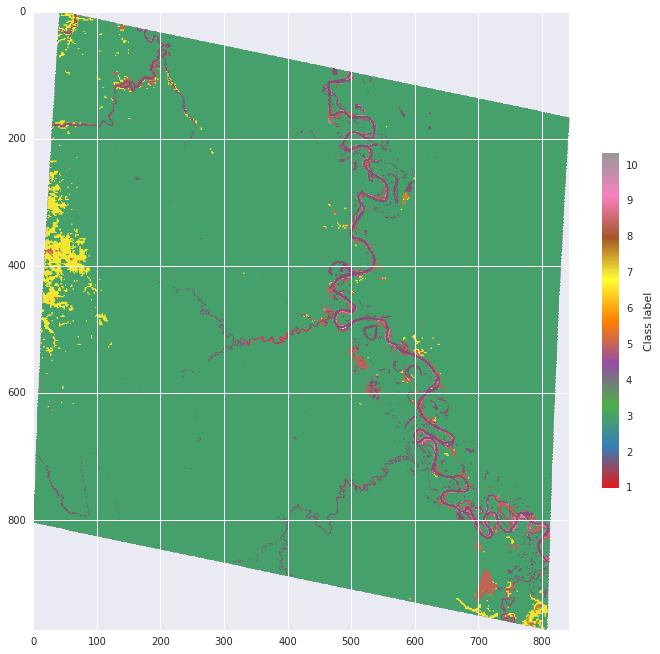

In [9]:
filename = download_tiff(stacked.select(['label']), scale=240)
with rasterio.open(filename) as r:
    labels = r.read(1).astype(float)
    labels[labels == 0] = np.nan
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(labels, cmap='Set1', vmin=0)#, vmax=17)
cb = plt.colorbar(im, ax=ax, shrink=0.5, label='Class label')
cb.ax.set_yticklabels(np.arange(1, 17));

In [ ]:
from itertools import product
def get_landsat_mosaic(paths, rows, year, month, day, dataset_path='LANDSAT/LC08/C01/T1_TOA'):
    start_date = '{}-{}-{}'.format(year, month, day)
    end_date = '{}-{}-{}'.format(year + 1, month, day)
    
    images = []
    for p, r in product(paths, rows):
        ims = ee.ImageCollection(dataset_path) \
            .filter(ee.Filter.eq('WRS_PATH', p)) \
            .filter(ee.Filter.eq('WRS_ROW', r)) \
            .filterDate(start_date, end_date)
        im = ee.Image(ims.sort('CLOUD_COVER').first())
        images.append(im.clip(im.geometry()))
        
    images = ee.ImageCollection.fromImages(ee.List(images))
    image = ee.Image(images.mosaic())
    
    return image.clip(image.geometry())

In [10]:
def add_cloud_score(image, cloud_thresh=CLOUD_THRESH):
    score = ee.Algorithms.Landsat.simpleCloudScore(image)
    return image.updateMask(score.select(['cloud']).lt(cloud_thresh))

In [63]:
TRAINING_BANDS = ['B6', 'B5', 'B4', 'B3', 'B2']
MODIS_KEEP_VALUES = [11, 13, 16]
JRC_VALUES = [2]
def add_labels(image, bands=TRAINING_BANDS, mask_channel=False):
    image = ee.Image(image)
  
    year = image.date().get('year').getInfo()
    month = image.date().get('month').getInfo()
    day = image.date().get('day').getInfo()

    data_mask = image.neq(ee.Number(0)).select('B1')
    
    modis_year = min(year, 2016)
    timestamp = '{}_01_01'.format(modis_year)
    modis = ee.Image('MODIS/006/MCD12Q1/{}'.format(timestamp)).select('LC_Type1')
    
    label_values = np.arange(0, 18)
    discard_values = list(set(label_values) - set(MODIS_KEEP_VALUES))
    for value in discard_values:
        modis = modis.multiply(modis.neq(ee.Number(value)))
        
    modis = modis.add(ee.Number(1))
    modis = modis.multiply(modis.neq(ee.Number(1)))

    clipped_labels = modis.clip(image.geometry())
    
    jrc_year = min(year, 2015)
    timestamp = '{:d}_{:02d}'.format(jrc_year, month)
    water = ee.Image('JRC/GSW1_0/MonthlyHistory/{}'.format(timestamp))
    for k in JRC_VALUES:
        mask = water.neq(ee.Number(k))
        clipped_labels = clipped_labels.multiply(mask)
        clipped_labels = clipped_labels.add(water.eq(ee.Number(k)))

    #stacked = image.select(bands).addBands(clipped_labels)
    stacked = clipped_labels
    new_bands = stacked.bandNames().getInfo()
    new_bands.remove('LC_Type1')
    new_bands.append('label')
    stacked = stacked.rename(new_bands).clip(image.geometry())

    stacked = stacked.updateMask(data_mask)

    if mask_channel:
        channel_mask = water.eq(ee.Number(2)).clip(image.geometry())
        channel_mask = channel_mask.focal_max(CHANNEL_MASK_RADIUS).focal_min(CHANNEL_MASK_RADIUS)
        stacked = stacked.updateMask(channel_mask)

    return image.select(bands).addBands(stacked)

In [65]:
  def get_landsat_composite(path, row, year, dataset_path='LANDSAT/LC08/C01/T1_TOA'):
    start_date = '{}-{}-{}'.format(year, 1, 1)
    end_date = '{}-{}-{}'.format(year + 1, 1, 1)
    
    images = ee.ImageCollection(dataset_path) \
        .filter(ee.Filter.eq('WRS_PATH', path)) \
        .filter(ee.Filter.eq('WRS_ROW', row)) \
        .filterDate(start_date, end_date) \
        .map(add_cloud_score) #\
        
    image = images.first()    
    mosaic = ee.Image(images.mosaic()).clip(image.geometry())
    
    return mosaic

In [66]:
test = get_landsat_composite(path, row, 2014)

[u'B1', u'B2', u'B3', u'B4', u'B5', u'B6', u'B7', u'B8', u'B9', u'B10', u'B11', u'BQA']


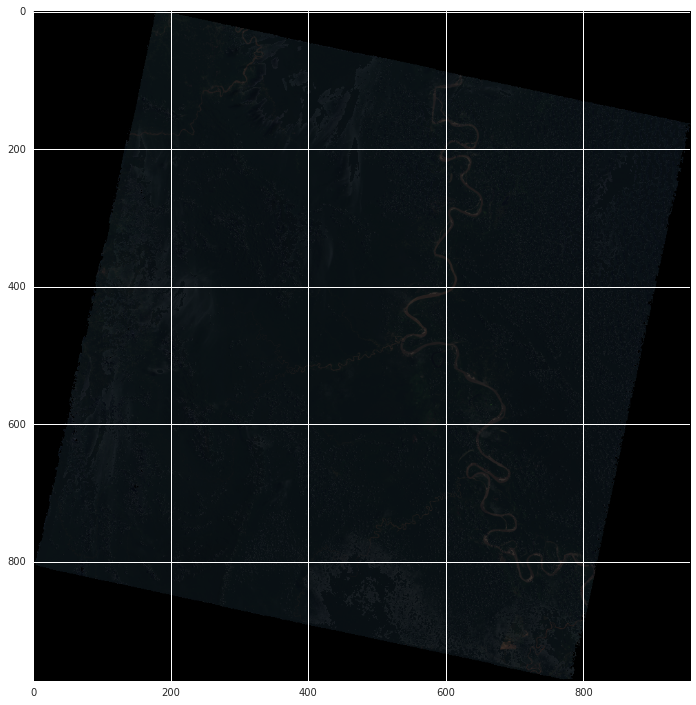

In [69]:
print(test.bandNames().getInfo())
filename = download_tiff(test.clip(test.geometry()), scale=240)
with rasterio.open(filename) as r:
    im = r.read()
rgb = np.stack([im[3], im[2], im[1]], axis=-1)
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(rgb)

In [ ]:
filename = download_tiff(mos.clip(mos.geometry()).select(['label']), scale=240)
with rasterio.open(filename) as r:
    labels = r.read(1).astype(float)
    labels[labels == 0] = np.nan
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(labels, cmap='Set1', vmin=0)#, vmax=17)
cb = plt.colorbar(im, ax=ax, shrink=0.5, label='Class label')
cb.ax.set_yticklabels(np.arange(1, 17));

In [ ]:
start_date = '2014-01-01'
end_date = '2015-01-01'
dataset_path = 'LANDSAT/LC08/C01/T1_TOA'
collection = ee.ImageCollection(dataset_path) \
    .filter(ee.Filter.eq('WRS_PATH', path)) \
    .filter(ee.Filter.eq('WRS_ROW', row)) \
    .filterDate(start_date, end_date)
ts = ndvi_timeseries(collection)
m = median_ndvi(collection)
sd = std_ndvi(collection).rename(['SD_NDVI'])

In [ ]:
stacked = form_labelled_image(path, row, year, month, day)
stacked = stacked.addBands(sd, ['SD_NDVI'])
filename = download_tiff(stacked, scale=200)

In [ ]:
bands = stacked.bandNames().getInfo()
print(bands)

In [ ]:
training = stacked.sample(numPixels=10000, seed=0).select(bands).filter(ee.Filter.neq('label', 0))
validation = stacked.sample(numPixels=10000, seed=1).select(bands).filter(ee.Filter.neq('label', 0))

In [ ]:
classifier = ee.Classifier.randomForest(10).train(training, 'label')

In [ ]:
classified = stacked.classify(classifier, 'classification')

In [ ]:
validated = validation.classify(classifier, 'classification')
accuracy = validated.errorMatrix('label', 'classification')
print(accuracy.accuracy().getInfo())

In [ ]:
error = compute_error_image(stacked.select(['label']), classified.clip(img.geometry()), 1)

In [ ]:
filename = download_tiff(error, scale=240)
with rasterio.open(filename) as r:
    err = r.read(1)
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(err, cmap='RdBu_r', vmin=-1, vmax=1) #, cmap=cmap, norm=norm)
cb = plt.colorbar(im, ax=ax, shrink=0.5, ticks=[-1, 0, 1])
cb.ax.set_yticklabels(['Omission', '', 'Comission']);

In [ ]:
filename = download_tiff(stacked.select(['label']).clip(img.geometry()), scale=200)

In [ ]:
with rasterio.open(filename) as r:
    labels = r.read(1).astype(float)
    labels[labels == 0] = np.nan
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(labels, cmap='Set1', vmin=0, vmax=17)
cb = plt.colorbar(im, ax=ax, shrink=0.5, label='Class label')
cb.ax.set_yticklabels(np.arange(1, 17));

In [ ]:
filename = download_tiff(classified.select(['classification']), scale=200)

In [ ]:
with rasterio.open(filename) as r:
    labels = r.read(1).astype(float)
    labels[labels == 0] = np.nan
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(labels == 1, cmap='Set1', vmin=0, vmax=17)
cb = plt.colorbar(im, ax=ax, shrink=0.5, label='Class label')
cb.ax.set_yticklabels(np.arange(1, 17));